# Data Workflow Lab 1 Solutions

There are many valid solutions.

In [1]:
% matplotlib inline

from collections import defaultdict
import datetime

from matplotlib import pyplot as plt
# Make the plots bigger
plt.rcParams['figure.figsize'] = 5, 5
import seaborn as sns

import numpy as np
import pandas as pd
from sklearn import linear_model

In [2]:
# Load the data

df = pd.read_csv("Iowa_Liquor_sales_sample_10pct.csv")

print(df.columns, df.shape, df.dtypes);

df.head();

Index(['Date', 'Store Number', 'City', 'Zip Code', 'County Number', 'County',
       'Category', 'Category Name', 'Vendor Number', 'Item Number',
       'Item Description', 'Bottle Volume (ml)', 'State Bottle Cost',
       'State Bottle Retail', 'Bottles Sold', 'Sale (Dollars)',
       'Volume Sold (Liters)', 'Volume Sold (Gallons)'],
      dtype='object') (270955, 18) Date                      object
Store Number               int64
City                      object
Zip Code                  object
County Number            float64
County                    object
Category                 float64
Category Name             object
Vendor Number              int64
Item Number                int64
Item Description          object
Bottle Volume (ml)         int64
State Bottle Cost         object
State Bottle Retail       object
Bottles Sold               int64
Sale (Dollars)            object
Volume Sold (Liters)     float64
Volume Sold (Gallons)    float64
dtype: object


## Clean the data

Let's practice our data cleaning skills on the Project 3 dataset. If you don't remember how to do any of these tasks, look back at your work from the previous weeks or search the internet. There are many blog articles and Stack Overflow posts that cover these topics.

You'll want to complete at least the following tasks:
* Remove redundant columns
* Remove "$" prices from characters and convert values to floats.
* Convert dates to pandas datetime objects
* Convert category floats to integers
* Drop or fill in bad values

In [15]:
# Remove redundant columns


In [3]:
# Remove $ from certain columns
cols = ["State Bottle Cost", "State Bottle Retail", "Sale (Dollars)"]
for col in cols:
    df[col] = df[col].apply(lambda x: float(x.strip("$")))
df.head();

In [4]:
# Convert dates
df["Date"] = pd.to_datetime(df["Date"], format="%m/%d/%Y")

In [5]:
# Drop bad values
df = df.dropna()

# Convert integers
df["County Number"] = df["County Number"].astype(int)
df["Category"] = df["Category"].astype(int)
df.head();

## Filter the Data

Some stores may have opened or closed in 2015. These data points will heavily skew our models, so we need to filter them out or find a way to deal with them.

You'll need to provide a summary in your project report about these data points. You may also consider using the monthly sales in your model and including other information (number of months or days each store is open) in your data to handle these unusual cases.

Let's record the first and last sales dates for each store. We'll save this information for later when we fit our models.

In [6]:
# Determine which stores were open all of 2015
# Find the first and last sales date.
dates = df.groupby(by=["Store Number"], as_index=False)
dates = dates.agg({"Date": [np.min, np.max]})
dates.columns = [' '.join(col).strip() for col in dates.columns.values]

# Filter out stores that opened or closed throughout the year
lower_cutoff = pd.Timestamp("20150301")
upper_cutoff = pd.Timestamp("20151001")
mask = (dates['Date amin'] < lower_cutoff) & (dates['Date amax'] > upper_cutoff)
good_stores = dates[mask]["Store Number"]
df = df[df["Store Number"].isin(good_stores)]

df.head()

,Date,Store Number,City,Zip Code,County Number,County,Category,Category Name,Vendor Number,Item Number,Item Description,Bottle Volume (ml),State Bottle Cost,State Bottle Retail,Bottles Sold,Sale (Dollars),Volume Sold (Liters),Volume Sold (Gallons)
0,2015-11-04,3717,SUMNER,50674,9,Bremer,1051100,APRICOT BRANDIES,55,54436,Mr. Boston Apricot Brandy,750,4.50,6.75,12,81.00,9.0,2.38
1,2016-03-02,2614,DAVENPORT,52807,82,Scott,1011100,BLENDED WHISKIES,395,27605,Tin Cup,750,13.75,20.63,2,41.26,1.5,0.40
2,2016-02-11,2106,CEDAR FALLS,50613,7,Black Hawk,1011200,STRAIGHT BOURBON WHISKIES,65,19067,Jim Beam,1000,12.59,18.89,24,453.36,24.0,6.34
3,2016-02-03,2501,AMES,50010,85,Story,1071100,AMERICAN COCKTAILS,395,59154,1800 Ultimate Margarita,1750,9.50,14.25,6,85.50,10.5,2.77
4,2015-08-18,3654,BELMOND,50421,99,Wright,1031080,VODKA 80 PROOF,297,35918,Five O'clock Vodka,1750,7.20,10.80,12,129.60,21.0,5.55


## Compute New Columns and Tables

Since we're trying to predict sales and/or profits, we'll want to compute some intermediate data. There are a lot of ways to do thisand good use of pandas is crucial. For example, for each transaction we may want to know:
* margin, retail cost minus bottle cost
* price per bottle
* price per liter

We'll need to make a new dataframe that indexes quantities by store:
* sales per store for all of 2015
* sales per store for Q1 2015
* sales per store for Q1 2016
* total volumes sold
* mean transaction revenue, gross margin, price per bottle, price per liter, etc.
* average sales per day
* number of days open

Make sure to retain other variables that we'll want to use to build our models, such as zip code, county number, city, etc. We recommend that you spend some time thinking about the model you may want to fit and computing enough of the suggested quantities to give you a few options.

Bonus tasks:
* Restrict your attention to stores that were open for all of 2015 and Q1 2016. Stores that opened or closed in 2015 will introduce outliers into your data.
* For each transaction we have the item category. You may be able to determine the store type (primarily wine, liquor, all types of alcohol, etc.) by the most common transaction category for each store. This could be a useful categorical variable for modelling. 

In [7]:
# Margin
df["Margin"] = (df["State Bottle Retail"] - df["State Bottle Cost"]) * df["Bottles Sold"]
df["Price per Liter"] = df["Sale (Dollars)"] / df["Volume Sold (Liters)"]
df.head()

,Date,Store Number,City,Zip Code,County Number,County,Category,Category Name,Vendor Number,Item Number,Item Description,Bottle Volume (ml),State Bottle Cost,State Bottle Retail,Bottles Sold,Sale (Dollars),Volume Sold (Liters),Volume Sold (Gallons),Margin,Price per Liter
0,2015-11-04,3717,SUMNER,50674,9,Bremer,1051100,APRICOT BRANDIES,55,54436,Mr. Boston Apricot Brandy,750,4.50,6.75,12,81.00,9.0,2.38,27.00,9.000000
1,2016-03-02,2614,DAVENPORT,52807,82,Scott,1011100,BLENDED WHISKIES,395,27605,Tin Cup,750,13.75,20.63,2,41.26,1.5,0.40,13.76,27.506667
2,2016-02-11,2106,CEDAR FALLS,50613,7,Black Hawk,1011200,STRAIGHT BOURBON WHISKIES,65,19067,Jim Beam,1000,12.59,18.89,24,453.36,24.0,6.34,151.20,18.890000
3,2016-02-03,2501,AMES,50010,85,Story,1071100,AMERICAN COCKTAILS,395,59154,1800 Ultimate Margarita,1750,9.50,14.25,6,85.50,10.5,2.77,28.50,8.142857
4,2015-08-18,3654,BELMOND,50421,99,Wright,1031080,VODKA 80 PROOF,297,35918,Five O'clock Vodka,1750,7.20,10.80,12,129.60,21.0,5.55,43.20,6.171429


In [16]:
# Sales per store, 2015

# Filter by our start and end dates
df.sort_values(by=["Store Number", "Date"], inplace=True)
start_date = pd.Timestamp("20150101")
end_date = pd.Timestamp("20151231")
mask = (df['Date'] >= start_date) & (df['Date'] <= end_date)
sales = df[mask]

# Group by store name
sales = sales.groupby(by=["Store Number"], as_index=False)
# Compute sums, means
sales = sales.agg({"Sale (Dollars)": [np.sum, np.mean],"Volume Sold (Liters)": [np.sum, np.mean],"Margin": np.mean,"Price per Liter": np.mean,"Zip Code": lambda x: x.iloc[0], "City": lambda x: x.iloc[0],"County Number": lambda x: x.iloc[0], "County": lambda x: x.iloc[0]})
# Collapse the column indices
sales.columns = [' '.join(col).strip() for col in sales.columns.values]
# Rename columns
sales.columns = [u'store_number', u'zipcode', u'County', u'2015_margin_avg_$', u'2015_price_avg_$pL',
                 u'2015_volume_total_L', u'2015_volume_avg_L', 
                 u'2015_sales_total_$', u'2015_sales_avg_$', 
                 u'city',u'County number']
# Quick check
sales.head()

,store_number,zipcode,County,2015_margin_avg_$,2015_price_avg_$pL,2015_volume_total_L,2015_volume_avg_L,2015_sales_total_$,2015_sales_avg_$,city,County number
0,2106,50613,Black Hawk,92.665779,17.844997,9719.85,18.478802,146038.70,277.640114,CEDAR FALLS,7
1,2113,50543,Webster,21.149932,18.507700,659.85,4.488776,9310.22,63.334830,GOWRIE,94
2,2130,50703,Black Hawk,95.215652,16.817589,6879.37,17.594297,111583.91,285.380844,WATERLOO,7
3,2152,50469,Cerro Gordo,18.351277,13.020765,633.37,4.491986,7721.08,54.759433,ROCKWELL,17
4,2178,52172,Allamakee,34.454430,16.053844,1917.12,8.089114,24324.18,102.633671,WAUKON,3


In [17]:
# Q1 sales, may want to also use aggregate as above to have more columns (means, etc.)

# Sales and volume 2015  Q1
start_date = pd.Timestamp("20150101")
end_date = pd.Timestamp("20150331")
df.sort_values(by=["Store Number", "Date"], inplace=True)
mask = (df['Date'] >= start_date) & (df['Date'] <= end_date)
df2 = df[mask].groupby(by=["Store Number"], as_index=False)["Sale (Dollars)"].sum()
sales["2015Q1_sales_total_$"] = df2["Sale (Dollars)"]
df2 = df[mask].groupby(by=["Store Number"], as_index=False)["Volume Sold (Liters)"].sum()
sales["2015Q1_volume_total_L"] = df2["Volume Sold (Liters)"]

# Sales 2016 Q1
start_date = pd.Timestamp("20160101")
end_date = pd.Timestamp("20160331")
df.sort_values(by=["Store Number", "Date"], inplace=True)
mask = (df['Date'] >= start_date) & (df['Date'] <= end_date)
df2 = df[mask].groupby(by=["Store Number"], as_index=False)["Sale (Dollars)"].sum()
sales["2016Q1_sales_total_$"] = df2["Sale (Dollars)"]
df2 = df[mask].groupby(by=["Store Number"], as_index=False)["Volume Sold (Liters)"].sum()
sales["2016Q1_volume_total_L"] = df2["Volume Sold (Liters)"]

sales.head()

,store_number,zipcode,County,2015_margin_avg_$,2015_price_avg_$pL,2015_volume_total_L,2015_volume_avg_L,2015_sales_total_$,2015_sales_avg_$,city,County number,2015Q1_sales_total_$,2015Q1_volume_total_L,2016Q1_sales_total_$,2016Q1_volume_total_L
0,2106,50613,Black Hawk,92.665779,17.844997,9719.85,18.478802,146038.70,277.640114,CEDAR FALLS,7,39287.29,2526.10,30478.75,2116.25
1,2113,50543,Webster,21.149932,18.507700,659.85,4.488776,9310.22,63.334830,GOWRIE,94,2833.25,177.11,2065.90,177.00
2,2130,50703,Black Hawk,95.215652,16.817589,6879.37,17.594297,111583.91,285.380844,WATERLOO,7,24272.57,1447.25,27856.11,1556.90
3,2152,50469,Cerro Gordo,18.351277,13.020765,633.37,4.491986,7721.08,54.759433,ROCKWELL,17,2003.46,151.74,904.66,87.50
4,2178,52172,Allamakee,34.454430,16.053844,1917.12,8.089114,24324.18,102.633671,WAUKON,3,5856.41,409.81,5588.50,520.80


(0, 50000)

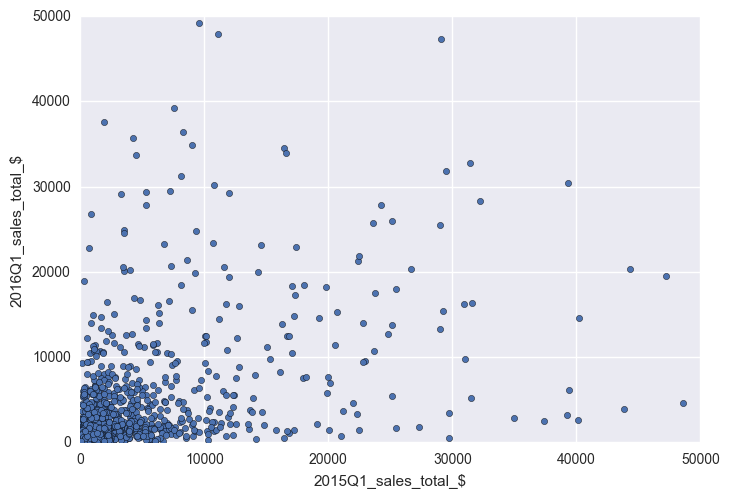

In [19]:
# Quick plot to check the computations
sales.plot(kind='scatter', x="2015Q1_sales_total_$", y="2016Q1_sales_total_$");
plt.xlim(0, 50000)
plt.ylim(0, 50000)

Proceed with any calculations that you need for your models, such as grouping
sales by zip code, most common vendor number per store, etc. Once you have finished adding columns, be sure to save the dataframe.

In [12]:
# Compute more things
# ...

In [20]:
# Save this dataframe

# Let's add the dates computed above to this data.
sales["First Date"] = dates['Date amin']
sales["Last Date"] = dates['Date amax']

sales.to_csv("sales_cleaned2.csv")